<a href="https://colab.research.google.com/github/civvic1/Movie_Recommender_System/blob/main/Copia_de_Copia_de_Copia_de_Movie_Recommender_System_ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final, df_links

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   983k      0 --:--:-- --:--:-- --:--:--  982k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [2]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
df_ratings.userId.count()

100836

In [4]:
df_links = pd.read_csv('data/ml-latest-small/links.csv')
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.00
1,2,113497,8844.00
2,3,113228,15602.00
3,4,114885,31357.00
4,5,113041,11862.00


##**2.2 Tratamiento de Datos**

In [5]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')
print(df_links.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   i

#Funcion procesamiento

In [6]:
#@title
import pandas as pd

def preprocesamiento():
    global df_movies, df_ratings, df_final, df_links
    # Eliminar registros con valores nulos en df_ratings y df_movies
    df_ratings = df_ratings.dropna()
    df_movies = df_movies.dropna()
    df_links = df_links.dropna()
    # Eliminar registros duplicados en df_movies usando la columna movieId como llave
    df_movies = df_movies.drop_duplicates(subset='movieId', keep='first').reset_index(drop=True)
    # Eliminar registros duplicados en df_ratings usando las columnas movieId y userId como llaves
    df_ratings = df_ratings.drop_duplicates(subset=['movieId', 'userId'], keep='first').reset_index(drop=True)
    # Eliminar registros duplicados en df_links usando la columna movieId como llave
    df_links = df_links.drop_duplicates(subset='movieId', keep='first').reset_index(drop=True)
    # Crear la columna 'content' reemplazando '|' por ' ' en la columna 'genres' de df_movies
    df_movies['content'] = df_movies['genres'].str.replace('|', ' ')
    # Crear la columna 'genre_set' como un set de géneros separados por '|'
    df_movies['genre_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))
    # Convertir la columna 'timestamp' a tipo datetime en df_ratings
    df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
    # Fusionar los DataFrames df_movies, df_ratings, y df_links usando la columna 'movieId'
    df_final = pd.merge(df_ratings, df_movies, on='movieId', how='inner')
    df_final = pd.merge(df_final, df_links, on='movieId', how='inner')
    # Crear una columna 'year' basada en el año de 'timestamp' en df_ratings
    df_final['year'] = df_final['timestamp'].dt.year
    # Eliminar la columna 'timestamp' si no es necesaria
    df_final.drop(columns=['timestamp'], inplace=True)
    return df_final

# Llamar a la función de preprocesamiento para crear df_final
df_final = preprocesamiento()


In [7]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')
print(df_links.info())
print('-------------')
print(df_final.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9734 entries, 

In [8]:
df_movies.head()

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Children, Adventure, Fantasy}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Drama, Romance, Comedy}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [9]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


In [10]:
df_final.head()

,userId,movieId,rating,title,genres,content,genre_set,imdbId,tmdbId,year
0,1,1,4.00,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",114709,862.00,2000
1,5,1,4.00,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",114709,862.00,1996
2,7,1,4.50,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",114709,862.00,2005
3,15,1,2.50,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",114709,862.00,2017
4,17,1,4.50,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",114709,862.00,2011


##**2.3 Análisis Exploratorio (EDA)**

In [11]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [12]:
df_movies.head()

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Children, Adventure, Fantasy}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Drama, Romance, Comedy}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


###Graficos EDA

<ipython-input-13-617305ad512c>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


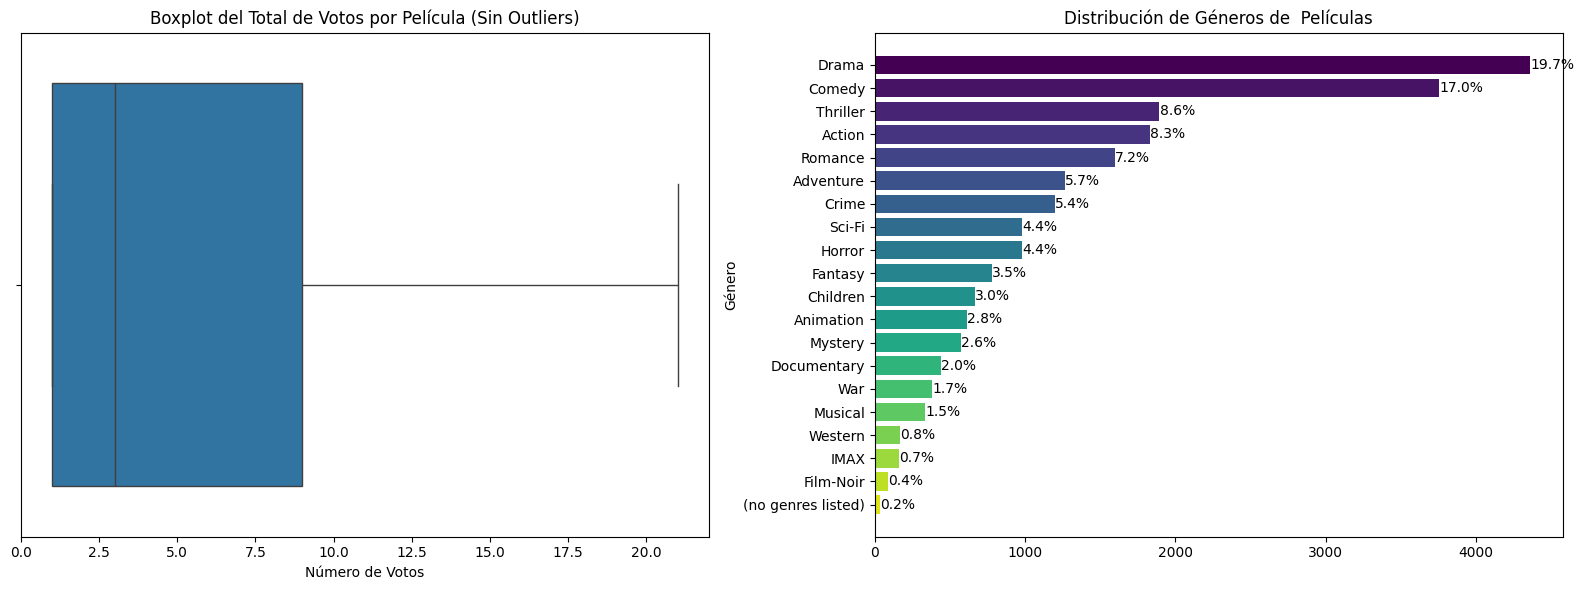

In [13]:
#@title

# Calcular el número de votos por película
votes_per_movie = df_ratings.groupby('movieId').size()

# Contar la distribución de géneros
genre_series = df_movies['genres'].str.split('|', expand=True).stack()
genre_counts = genre_series.value_counts()

# Ordenar los géneros en orden ascendente
genre_counts = genre_counts.sort_values(ascending=True)

# Crear la figura y los ejes para los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

# Crear el boxplot en el primer subplot
sns.boxplot(x=votes_per_movie, ax=ax1, showfliers=False)
ax1.set_title('Boxplot del Total de Votos por Película (Sin Outliers)')
ax1.set_xlabel('Número de Votos')

# Obtener el colormap 'viridis'
cmap = cm.get_cmap('viridis')

# Asignar colores en función del índice y luego invertir el orden
colors = [cmap(i / len(genre_counts)) for i in range(len(genre_counts))]
colors.reverse()  # Invertir el orden de los colores

# Crear el gráfico de barras horizontales en el segundo subplot
bars = ax2.barh(genre_counts.index, genre_counts, color=colors)
ax2.set_title('Distribución de Géneros de  Películas')
ax2.set_xlabel('')
ax2.set_ylabel('Género')

# Añadir los porcentajes encima de cada barra
for bar in bars:
    width = bar.get_width()
    percentage = width / genre_counts.sum() * 100
    ax2.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{percentage:.1f}%',
             va='center', ha='left')

# Ajustar el diseño para que no se sobrepongan
plt.tight_layout()
plt.show()


In [14]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469248
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


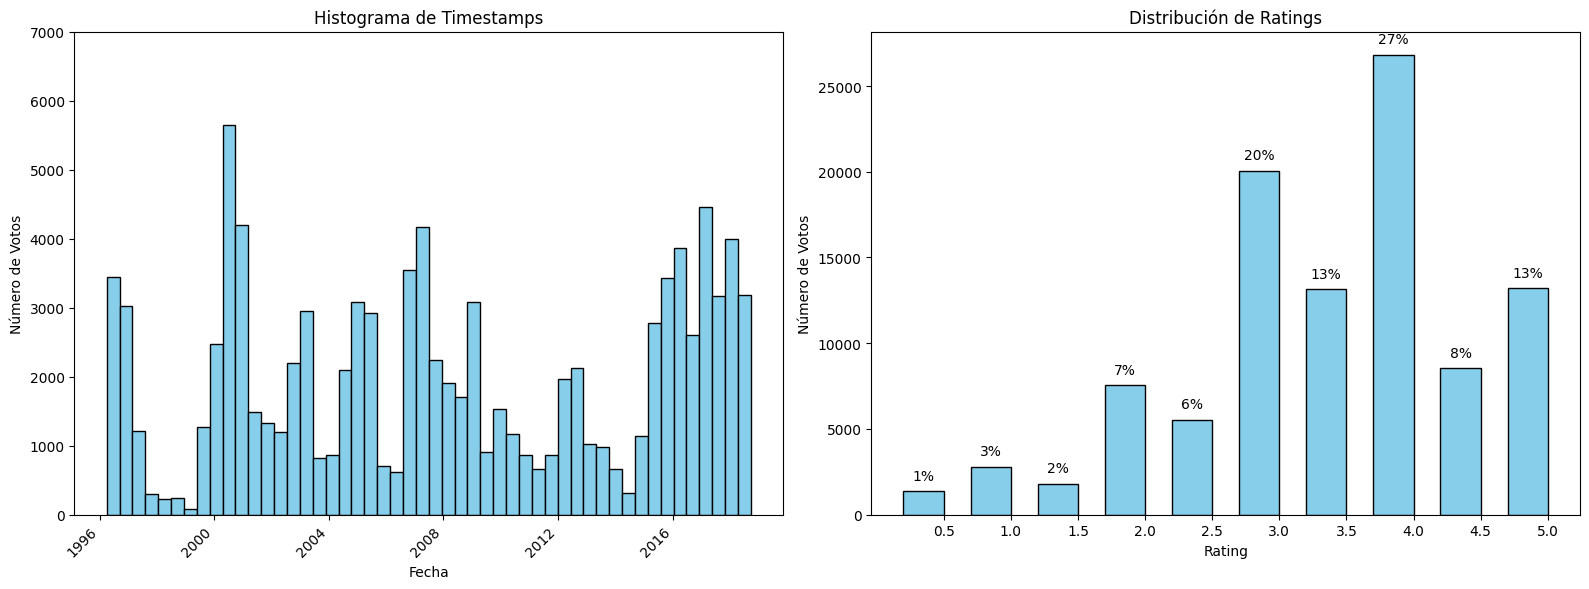

In [15]:

# Crear la figura y los ejes para los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

# Crear un histograma de la columna timestamp en el primer subplot
ax1.hist(df_ratings['timestamp'], bins=50, color='skyblue', edgecolor='black')
ax1.set_title('Histograma de Timestamps')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Número de Votos')
ax1.xaxis.set_major_locator(mdates.YearLocator(4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Establecer el límite superior del eje y en 7,000
ax1.set_ylim(0, 7000)

# Calcular la distribución de ratings
rating_counts = df_ratings['rating'].value_counts().sort_index()

# Crear un gráfico de barras para la distribución de ratings en el segundo subplot
bar_width = 0.3  # Ancho de las barras más reducido
bar_positions = rating_counts.index - bar_width / 2  # Desplazar las barras para que no se peguen
bars = ax2.bar(bar_positions, rating_counts, width=bar_width, color='skyblue', edgecolor='black')
ax2.set_title('Distribución de Ratings')
ax2.set_xlabel('Rating')
ax2.set_ylabel('Número de Votos')
# Ajustar el eje x para que tenga intervalos de medio punto
ax2.set_xticks(np.arange(0.5, 5.5, 0.5))

# Calcular y mostrar los porcentajes encima de cada barra
total = rating_counts.sum()
for bar in bars:
    height = bar.get_height()
    percentage = (height / total) * 100
    ax2.text(bar.get_x() + bar.get_width() / 2, height + 500, f'{percentage:.0f}%',
             ha='center', va='bottom', fontsize=10)

# Ajustar el diseño para que no se sobrepongan
plt.tight_layout()
plt.show()


In [16]:
df_final.describe()

,userId,movieId,rating,imdbId,tmdbId,year
count,100823.00,100823.00,100823.00,100823.00,100823.00,100823.00
mean,326.13,19435.44,3.50,351570.43,20105.46,2007.72
std,182.62,35532.29,1.04,622092.16,53274.14,6.89
min,1.00,1.00,0.50,417.00,2.00,1996.00
25%,177.00,1199.00,3.00,99685.00,712.00,2002.00
50%,325.00,2991.00,3.50,118771.00,6957.00,2007.00
75%,477.00,8120.00,4.00,314979.00,11635.00,2015.00
max,610.00,193609.00,5.00,8391976.00,525662.00,2018.00


#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

##promedio bayesiano:

$
\text{WR} = \frac{v}{v + m} \times R + \frac{m}{v + m} \times C
$





In [43]:
import pandas as pd

def recomendacion_populares(genero=None):
    global df_final, df_movies, df_links, df_ratings

    # Filtrar las películas por el género seleccionado si se especifica
    if genero:
        df_final_filtrado = df_final[df_final['genres'].str.contains(genero, case=False)]
    else:
        df_final_filtrado = df_final

    # Calcular cuántas veces cada película ha sido votada
    votos_por_pelicula = df_final_filtrado['title'].value_counts()

    # Calcular el número de votos por cada película y su rating promedio
    vote_count = df_final_filtrado.groupby('title')['rating'].size()
    mean_rating = df_final_filtrado.groupby('title')['rating'].mean()

    # Calcular el promedio general de calificaciones de todas las películas
    C = df_final_filtrado['rating'].mean()

    # Definir un valor mínimo de votos para que una película sea considerada
    m = votos_por_pelicula.quantile(0.90)  # Usamos el percentil 90 como umbral mínimo

    # Filtrar películas que tienen más de m votos
    df_popular_movies = df_final_filtrado[df_final_filtrado['title'].isin(vote_count[vote_count >= m].index)]

    # Recalcular el número de votos y el rating promedio de las películas filtradas
    vote_count = df_popular_movies.groupby('title')['rating'].size()
    mean_rating = df_popular_movies.groupby('title')['rating'].mean()

    # Calcular el promedio bayesiano para cada película
    weighted_score = (vote_count / (vote_count + m) * mean_rating) + (m / (vote_count + m) * C)

    # Crear un nuevo DataFrame con title, mean_rating, vote_count y weighted_score
    df_movie_stats = pd.DataFrame({
        'title': mean_rating.index,
        'mean_rating': mean_rating.values,
        'vote_count': vote_count.values,
        'weighted_score': weighted_score.values
    }).reset_index(drop=True)

    # Añadir la columna movieId al DataFrame con base en el df_final
    df_movie_stats['movieId'] = df_final_filtrado.groupby('title')['movieId'].first().reindex(mean_rating.index).values

    # Filtrar las 10 películas con el promedio bayesiano más alto basado en weighted_score
    top_10_populares = df_movie_stats.nlargest(10, 'weighted_score')

    # Ordenar las 10 películas por weighted_score
    top_10_ordenadas_por_score = top_10_populares.sort_values(by='weighted_score', ascending=False)

    # Seleccionar las columnas deseadas incluyendo vote_count
    result = top_10_ordenadas_por_score[['movieId', 'title', 'mean_rating', 'vote_count', 'weighted_score']].reset_index(drop=True)

    # Imprimir las 10 películas más populares ordenadas por weighted_score
    result.head(10)

    # Retornar el DataFrame con los resultados
    return result

print("Ejemplo de llamada a la función para obtener recomendaciones de un género específico. En este caso Adventure\n")
recomendacion_populares(genero='Adventure')  # Cambia genero='Action' por el género que prefieras


Ejemplo de llamada a la función para obtener recomendaciones de un género específico. En este caso Adventure



,movieId,title,mean_rating,vote_count,weighted_score
0,260,Star Wars: Episode IV - A New Hope (1977),4.23,251,4.11
1,1196,Star Wars: Episode V - The Empire Strikes Back...,4.22,211,4.08
2,1198,Raiders of the Lost Ark (Indiana Jones and the...,4.21,200,4.07
3,1197,"Princess Bride, The (1987)",4.23,142,4.04
4,1210,Star Wars: Episode VI - Return of the Jedi (1983),4.14,196,4.01
5,7153,"Lord of the Rings: The Return of the King, The...",4.12,185,3.99
6,1136,Monty Python and the Holy Grail (1975),4.16,136,3.99
7,4993,"Lord of the Rings: The Fellowship of the Ring,...",4.11,198,3.99
8,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.16,87,3.92
9,1270,Back to the Future (1985),4.04,171,3.92


##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**
$
J(A, B) = \large \frac{|A \cap B|}{|A \cup B|}
$

In [40]:
#@title
def similitud_jaccard(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)
def recomendacion_jaccard(item_id, df_items, n_recommendations=5):
    """
    Recomendación de ítems basada en la similitud de Jaccard
    """
    # Obtener el conjunto de características del ítem de entrada
    input_features = df_items[df_items['movieId'] == item_id]['genre_set'].values[0]

    # Calcular la similitud de Jaccard entre el ítem de entrada y todos los demás ítems
    df_items['similaridad'] = df_items['genre_set'].apply(lambda x: similitud_jaccard(set(input_features), set(x)))

    # Ordenar los ítems por su similitud, excluyendo el ítem de entrada
    df_items = df_items[df_items['movieId'] != item_id].sort_values('similaridad', ascending=False).reset_index(drop=True)

    # Retornar los ítems más similares
    return df_items.head(n_recommendations)
print("recomendaciones por movieId:1\n")
recomendaciones = recomendacion_jaccard(1, df_movies, n_recommendations=10)
recomendaciones

recomendaciones por movieId:1



,movieId,title,genres,content,genre_set,similaridad
0,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
1,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
2,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
3,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
4,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
5,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
6,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
7,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
8,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00
9,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Adventure, Animation, Children, Comedy}",1.00


In [20]:
def similitud_jaccard(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

def recomendacion_jaccard_por_titulo(titulo, df_items, n_recommendations=5):
    """
    Recomendación de ítems basada en la similitud de Jaccard según el título de la película.
    """
    # Buscar el movieId correspondiente al título proporcionado
    if titulo not in df_items['title'].values:
        print(f"Error: El título '{titulo}' no se encuentra en la base de datos.")
        return None

    item_id = df_items[df_items['title'] == titulo]['movieId'].values[0]

    # Obtener el conjunto de características del ítem de entrada
    input_features = df_items[df_items['movieId'] == item_id]['genre_set'].values[0]

    # Calcular la similitud de Jaccard entre el ítem de entrada y todos los demás ítems
    df_items['similaridad'] = df_items['genre_set'].apply(lambda x: similitud_jaccard(set(input_features), set(x)))

    # Ordenar los ítems por su similitud, excluyendo el ítem de entrada
    df_items = df_items[df_items['movieId'] != item_id].sort_values('similaridad', ascending=False).reset_index(drop=True)

    # Retornar los ítems más similares
    result = df_items.head(n_recommendations)

    # Mostrar las recomendaciones con título y similitud
    print(f"Recomendaciones para '{titulo}':")
    print(result[['movieId','title', 'similaridad']])

    return result

# Ejemplo de llamada a la función para obtener recomendaciones basadas en un título de película
recomendaciones = recomendacion_jaccard_por_titulo('Toy Story (1995)', df_movies, n_recommendations=10)


Recomendaciones para 'Toy Story (1995)':
   movieId                                              title  similaridad
0     3114                                 Toy Story 2 (1999)         1.00
1    45074                                   Wild, The (2006)         1.00
2    65577                     Tale of Despereaux, The (2008)         1.00
3     3754     Adventures of Rocky and Bullwinkle, The (2000)         1.00
4     4886                              Monsters, Inc. (2001)         1.00
5   103755                                       Turbo (2013)         1.00
6   166461                                       Moana (2016)         1.00
7     2294                                        Antz (1998)         1.00
8     4016                   Emperor's New Groove, The (2000)         1.00
9    91355  Asterix and the Vikings (Astérix et les Viking...         1.00


In [21]:
# Ejemplo: Obtener el movieId para el título 'Toy Story (1995)'
titulo = 'Toy Story (1995)'
movie_id = df_movies[df_movies['title'] == titulo]['movieId'].values[0]
print(f"MovieId para '{titulo}': {movie_id}")


MovieId para 'Toy Story (1995)': 1


In [22]:
# Función original usando movieId
recomendaciones_por_id = recomendacion_jaccard(movie_id, df_movies, n_recommendations=10)

# Función modificada usando título
recomendaciones_por_titulo = recomendacion_jaccard_por_titulo(titulo, df_movies, n_recommendations=10)

# Comparar los resultados
print("Recomendaciones por movieId:")
print(recomendaciones_por_id[['title', 'similaridad']])

print("\nRecomendaciones por título:")
print(recomendaciones_por_titulo[['title', 'similaridad']])


Recomendaciones para 'Toy Story (1995)':
   movieId                                              title  similaridad
0     3114                                 Toy Story 2 (1999)         1.00
1    45074                                   Wild, The (2006)         1.00
2    65577                     Tale of Despereaux, The (2008)         1.00
3     3754     Adventures of Rocky and Bullwinkle, The (2000)         1.00
4     4886                              Monsters, Inc. (2001)         1.00
5   103755                                       Turbo (2013)         1.00
6   166461                                       Moana (2016)         1.00
7     2294                                        Antz (1998)         1.00
8     4016                   Emperor's New Groove, The (2000)         1.00
9    91355  Asterix and the Vikings (Astérix et les Viking...         1.00
Recomendaciones por movieId:
                                               title  similaridad
0                                 Toy S

###**3.2.2 Similitud de Coseno con TF-IDF**

$$\text{Similitud del coseno} = \cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}$$


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def recomendacion_tf_idf(movieId, n_recommendations=5):
    spanish_stop_words = ['de', 'la', 'que', 'el', 'en', 'un', 'con', 'y', 'a', 'los', 'se', 'no', 'me', 'si', 'por', 'su', 'para', 'esta', 'tener', 'hacer', 'poder', 'decir', 'querer', 'poder', 'ser', 'tener', 'hacer']
    # Crear la matriz TF-IDF
    tfidf_vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies['content'])

    # Calcular la matriz de similitud de coseno
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Obtener el índice de la película dada
    idx = df_movies[df_movies['movieId'] == movieId].index[0]

    # Obtener las puntuaciones de similitud de coseno para todas las películas
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordenar las películas por las puntuaciones de similitud en orden descendente
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Filtrar la película de entrada para asegurarse de que no se recomiende a sí misma
    sim_scores = [(i, score) for i, score in sim_scores if i != idx]

    # Obtener los índices de las n_recommendations películas más similares
    top_n = sim_scores[:n_recommendations]

    # Obtener los índices y distancias de las películas recomendadas
    recommended_movies = [(df_movies.iloc[i]['movieId'], df_movies.iloc[i]['title'], df_movies.iloc[i]['genres'], score) for i, score in top_n]

    # Convertir la lista de recomendaciones en un DataFrame
    recommended_movies_df = pd.DataFrame(recommended_movies, columns=['movieId', 'title', 'genres', 'similarity'])

    # Reducir los decimales a dos
    recommended_movies_df['similarity'] = recommended_movies_df['similarity'].round(2)

    return recommended_movies_df
    print("recommended_movies_df por usuario: 58559")
recommended_movies = recomendacion_tf_idf(58559)
recommended_movies

,movieId,title,genres,similarity
0,109850,Need for Speed (2014),Action|Crime|Drama|IMAX,1.00
1,33794,Batman Begins (2005),Action|Crime|IMAX,0.96
2,86644,"Fast Five (Fast and the Furious 5, The) (2011)",Action|Crime|Drama|Thriller|IMAX,0.93
3,62081,Eagle Eye (2008),Action|Crime|Thriller|IMAX,0.89
4,100498,"Good Day to Die Hard, A (2013)",Action|Crime|Thriller|IMAX,0.89


##**3.3 Recomendación Collaborative Filtering**

In [29]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Crear la matriz de calificaciones con usuarios como filas y películas como columnas
ratings_matrix = df_final.pivot(index='userId', columns='movieId', values='rating')

# Calcular el promedio de calificaciones por usuario
avg_ratings = ratings_matrix.mean(axis=1)

# Normalizar la matriz de calificaciones restando el promedio de cada usuario
ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0).fillna(0)

# Entrenar el modelo KNN usando la similitud del coseno
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(ratings_matrix_normalized.values)

def recomendacion_knn(usuario, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
    if isinstance(usuario, int):
        # Si el input es un ID de usuario existente, encontrar su índice en ratings_matrix
        user_idx = ratings_matrix.index.get_loc(usuario)
        distances, indices = knn_model.kneighbors(ratings_matrix_normalized.iloc[user_idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    else:
        # Si el input no es un ID, tratarlo como un nuevo usuario
        new_user_ratings = pd.Series(usuario, index=ratings_matrix.columns).fillna(0)
        new_user_normalized = new_user_ratings - new_user_ratings.mean()
        distances, indices = knn_model.kneighbors(new_user_normalized.values.reshape(1, -1), n_neighbors=n_recommendations + 1)

    # Ajustar las distancias y los índices para ignorar el propio usuario
    distances = distances.flatten()[1:]
    indices = indices.flatten()[1:]

    # Obtener las calificaciones de los usuarios similares
    similar_users = ratings_matrix_normalized.iloc[indices]

    # Calcular las calificaciones promedio ponderadas para las películas
    mean_ratings = similar_users.T.dot(1 - distances) / (1 - distances).sum()
    mean_ratings_df = pd.DataFrame(mean_ratings, index=ratings_matrix.columns, columns=['mean_rating'])
    mean_ratings_df = mean_ratings_df.dropna()

    # Filtrar películas que el usuario ya ha visto
    user_seen_movies = ratings_matrix.loc[usuario].dropna().index
    recommendations = mean_ratings_df[~mean_ratings_df.index.isin(user_seen_movies)]

    # Ordenar las recomendaciones por la calificación promedio en orden descendente
    recommendations = recommendations.sort_values(by='mean_rating', ascending=False)

    # Seleccionar las mejores recomendaciones
    recommendations = recommendations.head(n_recommendations)

    # Añadir información de las películas a las recomendaciones
    movie_info = df_movies[['movieId', 'title', 'genres']].drop_duplicates().set_index('movieId')
    recommendations = recommendations.join(movie_info).reset_index()

    return recommendations

recomendaciones = recomendacion_knn(15, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model)
print("Recomendaciones por usurio:15\n")
recomendaciones

Recomendaciones por usurio:15



,movieId,mean_rating,title,genres
0,50,0.39,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
1,593,0.38,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2,924,0.30,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
3,110,0.29,Braveheart (1995),Action|Drama|War
4,497,0.29,Much Ado About Nothing (1993),Comedy|Romance
5,1221,0.27,"Godfather: Part II, The (1974)",Crime|Drama
6,1732,0.25,"Big Lebowski, The (1998)",Comedy|Crime
7,4973,0.23,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
8,112183,0.22,Birdman: Or (The Unexpected Virtue of Ignoranc...,Comedy|Drama
9,1036,0.22,Die Hard (1988),Action|Crime|Thriller
